# [教學目標]
- 綜合到目前為止所教的內容, 提交一次作答結果吧!!

# [範例重點]
- 資料清理 (In[4], Out[4]) 
- 前處理 : MinMaxScaler, Imputer (In[4], Out[4])   
- Heatmap 的進階用法 : 散佈圖, KDE, 密度圖 (In[6], Out[6])
- 輸出值的紀錄 (In[8], Out[8])

In [43]:
# Import 需要的套件
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

### 仿造之前做過的處理

In [44]:
# 設定 data_path
os.chdir(r'C:\Users\戴嘉萱\Documents\marching learning100day\all data')

# 讀取檔案
app_train = pd.read_csv('application_train.csv')
app_test = pd.read_csv('application_test.csv')


In [45]:
# 種類 2 種以下的類別型欄位轉標籤編碼 (Label Encoding)
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le_count = 0

# 檢查每一個 column
for col in app_train:
    if app_train[col].dtype == 'object':
        
        # 如果只有兩種值的類別型欄位
        if len(list(app_train[col].unique())) <= 2:
            print(col)
            # 就做 Label Encoder
            le.fit(app_train[col])
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # 紀錄有多少個 columns 被標籤編碼過
            le_count += 1

app_test[['NAME_CONTRACT_TYPE','FLAG_OWN_CAR','FLAG_OWN_REALTY']].head()

NAME_CONTRACT_TYPE
FLAG_OWN_CAR
FLAG_OWN_REALTY


,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY
0,0,0,1
1,0,0,1
2,0,1,1
3,0,0,1
4,0,1,0


In [46]:
            
# 標籤編碼 (2種類別) 欄位轉 One Hot Encoding            
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)
app_train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,...,HOUSETYPE_MODE_terraced house,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes
0,100002,1,0,0,1,0,202500.0,406597.5,24700.5,351000.0,...,0,0,0,0,0,0,1,0,1,0
1,100003,0,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,...,0,1,0,0,0,0,0,0,1,0
2,100004,0,1,1,1,0,67500.0,135000.0,6750.0,135000.0,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,0,1,0,135000.0,312682.5,29686.5,297000.0,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,0,1,0,121500.0,513000.0,21865.5,513000.0,...,0,0,0,0,0,0,0,0,0,0


In [47]:
# 受雇日數為異常值的資料, 另外設一個欄位記錄, 並將異常的日數轉成空值 (np.nan)
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

# 出生日數 (DAYS_BIRTH) 取絕對值 
app_train['DAYS_BIRTH'] = abs(app_train['DAYS_BIRTH'])
app_test['DAYS_BIRTH'] = abs(app_test['DAYS_BIRTH'])

### 做好前處理
開始擬合模型之前，我們要確保 training & testing data 的欄位數量一致，原因是因為 One hot encoding 會製造多的欄位，有些類別出現在 training data 而沒有出現 testing data 中，我們就要把這些多餘的欄位去除

In [48]:
train_labels = app_train['TARGET']

# 調整欄位數, 移除出現在 training data 而沒有出現 testing data 中的欄位
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

In [51]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer 
# 特徵欄位清單
train = app_train
features = list(train.columns)

# 複製 test 資料
test = app_test.copy()

# 填補器 : 設定缺失值補中位數
imputer = SimpleImputer(missing_values=np.nan, strategy='median')

# 縮放器 : 設定特徵縮放到 0~1 區間
scaler = MinMaxScaler(feature_range = (0, 1))

# 填補器載入個欄中位數
imputer.fit(train)

# 將中位數回填 train, test 資料中的空缺值
train = imputer.transform(train)
test = imputer.transform(app_test)

# 縮放器載入 train 的上下限, 對 train, test 進行縮放轉換
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 240)
Testing data shape:  (48744, 240)


### Fit the model

In [52]:
from sklearn.linear_model import LogisticRegression

# 設定模型與模型參數
log_reg = LogisticRegression(C = 0.0001)

# 使用 Train 資料訓練模型
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

模型 fit 好以後，就可以用來預測 testing data 中的客戶違約遲繳貸款的機率咯! (記得要用 predict_proba 才會輸出機率)

In [55]:
# 用模型預測結果
# 請注意羅吉斯迴歸是分類預測 (會輸出 0 的機率, 與 1 的機率), 而我們只需要留下 1 的機率這排
log_reg_pred = log_reg.predict_proba(test)[:, 1]
log_reg.predict_proba(test)

array([[0.93461654, 0.06538346],
       [0.88264555, 0.11735445],
       [0.93202626, 0.06797374],
       ...,
       [0.93362914, 0.06637086],
       [0.92780523, 0.07219477],
       [0.91025811, 0.08974189]])

### 儲存預測結果

In [56]:
# 計算提交結果
submit = app_test[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

submit.head()

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,SK_ID_CURR,TARGET
0,100001,0.065383
1,100005,0.117354
2,100013,0.067974
3,100028,0.070889
4,100038,0.117988


## 練習時間
將你的結果存成 csv, 上傳你的第一份 Kaggle 成績

Hints: https://stackoverflow.com/questions/16923281/pandas-writing-dataframe-to-csv-file

In [61]:
submit.to_csv('homework.csv',index=False)

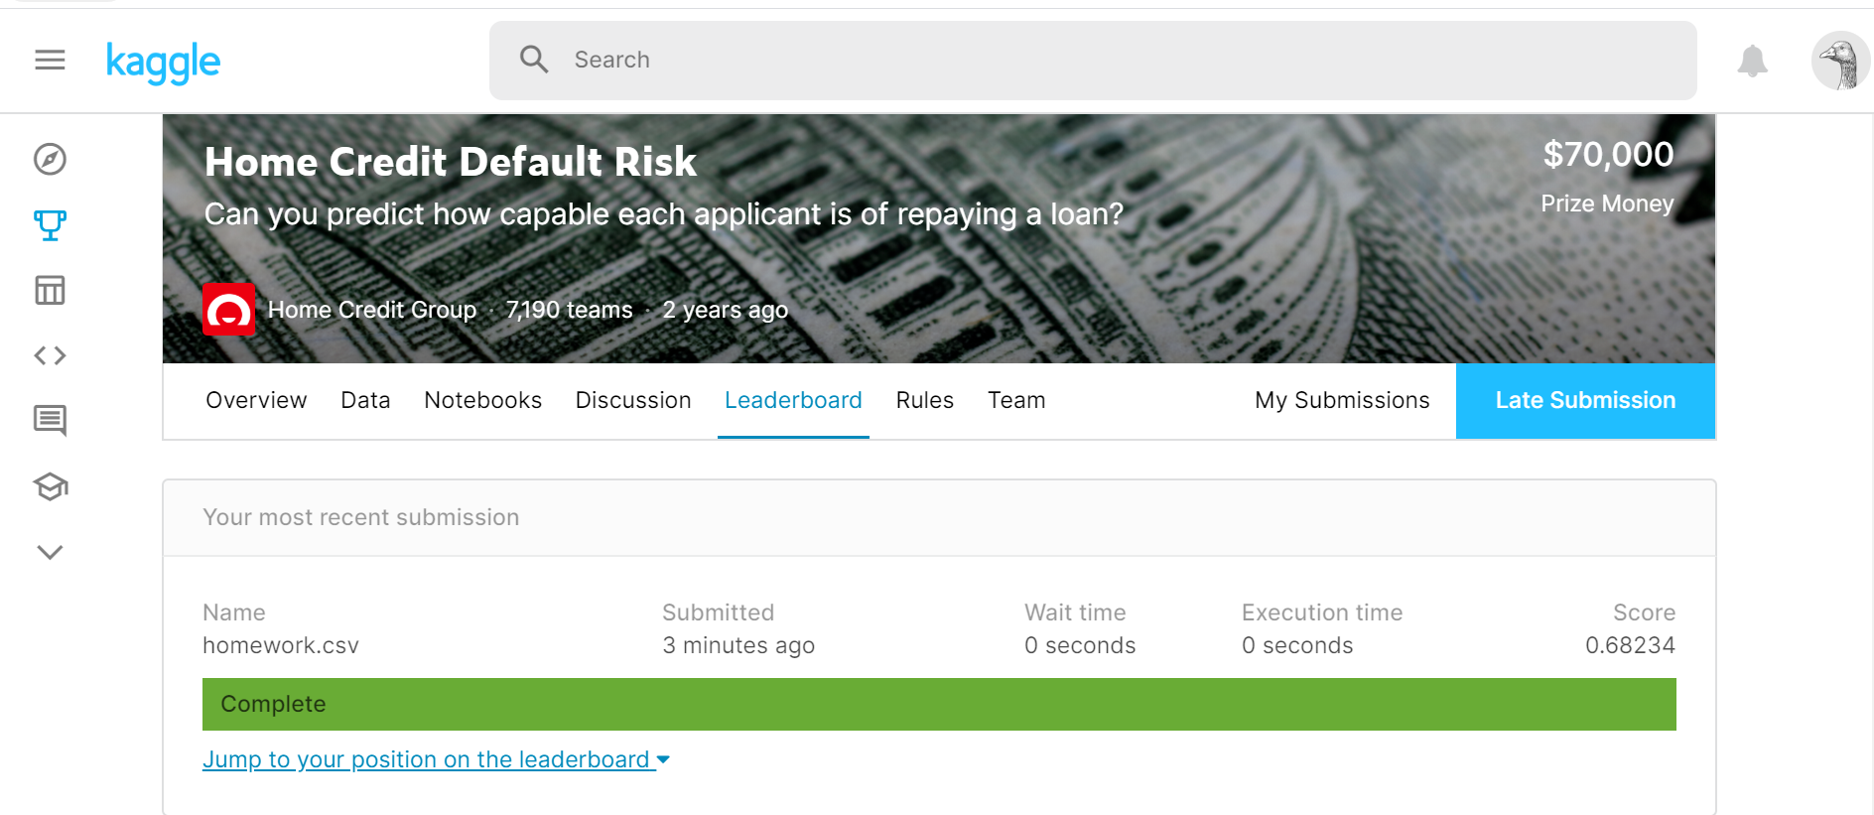
